In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# 1. Load data

In [2]:
df = pd.read_csv('data/DadosFinaisOutliersRemoved.csv')

# df.drop('populacao_estimada', axis=1, inplace=True)
# df.drop('populacao_estimada', axis=1, inplace=True)
df_x = df.copy()
df_x.drop('furtos_hab', axis=1, inplace=True)
df_x.drop('homicidios_hab', axis=1, inplace=True)
df_x.drop('NO_MUNICIPIO', axis=1, inplace=True)

df_y_furtos = df['furtos_hab'].copy()
df_y_homicidios = df['homicidios_hab'].copy()


# 2. Train and test models

## 2.1. Regression Tree

In [3]:
%%time
def dtr_model(X, y):
# Perform Grid-Search
    md_range = [3,4,5,6,7,8,9,10, None]
    parameters = {'max_depth': md_range}

    gsc = GridSearchCV(
        estimator=DecisionTreeRegressor(),
        param_grid=parameters,
        cv=5, scoring='neg_mean_squared_error', verbose=0)

    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_

    dtr = DecisionTreeRegressor(max_depth=best_params["max_depth"], random_state=False)
    # Perform K-Fold CV
    scores = cross_val_score(dtr, X, y, cv=10, scoring='neg_mean_squared_error')

    return scores, dtr, best_params

dtr_scores_furtos, dtr_furtos, dtr_best_params_furtos = dtr_model(df_x, df_y_furtos)
dtr_scores_homicidios, dtr_homicidios, dtr_best_params_homicidios = dtr_model(df_x, df_y_homicidios)

Wall time: 1.24 s


## 2.2. Random Forest Regressor

In [4]:
%%time
def rfr_model(X, y):
# Perform Grid-Search
    md_range = [3,4,5,6,7,8,9,10, None]
    parameters = {'max_depth': md_range, 'n_estimators': (10, 50, 100, 1000)}

    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid=parameters,
        cv=5, scoring='neg_mean_squared_error', verbose=0)

    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_

    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_squared_error')

    return scores, rfr, best_params

rfr_scores_furtos, rfr_furtos, rfr_best_params_furtos = rfr_model(df_x, df_y_furtos)
rfr_scores_homicidios, rfr_homicidios, rfr_best_params_homicidios = rfr_model(df_x, df_y_homicidios)

Wall time: 8min 59s


## 2.3. Gradient Boosting Regressor

In [5]:
%%time
def gbr_model(X, y):
# Perform Grid-Search
    learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
    n_estimators = [16, 32, 64, 100, 200]
    max_depths = [5, 10, 15, 20, 30]
    
    parameters = {'learning_rate': learning_rates, 'n_estimators': n_estimators, 'max_depth': max_depths}

    gsc = GridSearchCV(
        estimator=GradientBoostingRegressor(),
        param_grid=parameters,
        cv=5, scoring='neg_mean_squared_error', verbose=0)

    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_

    gbr = GradientBoostingRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)
    # Perform K-Fold CV
    scores = cross_val_score(gbr, X, y, cv=10, scoring='neg_mean_squared_error')

    return scores, gbr, best_params

gbr_scores_furtos, gbr_furtos, gbr_best_params_furtos = gbr_model(df_x, df_y_furtos)
gbr_scores_homicidios, gbr_homicidios, br_best_params_homicidios = gbr_model(df_x, df_y_homicidios)

Wall time: 25min 12s


# 3. Results
## 3.3. Average of mean Squard Error for each model

<AxesSubplot:xlabel='target_data'>

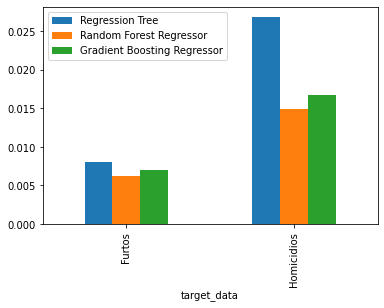

In [6]:
dict_scores_furtos = {'Regression Tree': np.abs(dtr_scores_furtos), 'Random Forest Regressor': np.abs(rfr_scores_furtos), 
                      'Gradient Boosting Regressor': np.abs(gbr_scores_furtos)}
df_scores_furtos = pd.DataFrame(dict_scores_furtos)
df_scores_furtos['target_data'] = 'Furtos'

dict_scores_homicidios = {'Regression Tree': np.abs(dtr_scores_homicidios), 'Random Forest Regressor': np.abs(rfr_scores_homicidios), 
                          'Gradient Boosting Regressor': np.abs(gbr_scores_homicidios)}
df_scores_homicidios = pd.DataFrame(dict_scores_homicidios)
df_scores_homicidios['target_data'] = 'Homicidios'

df_avg_scores = pd.concat([df_scores_furtos.groupby('target_data', as_index=False).mean(), 
                           df_scores_homicidios.groupby('target_data', as_index=False).mean()])

df_avg_scores.plot.bar(x='target_data')

## 3.2. Models visualization
### 3.2.1. Theft data

<AxesSubplot:xlabel='NO_MUNICIPIO'>

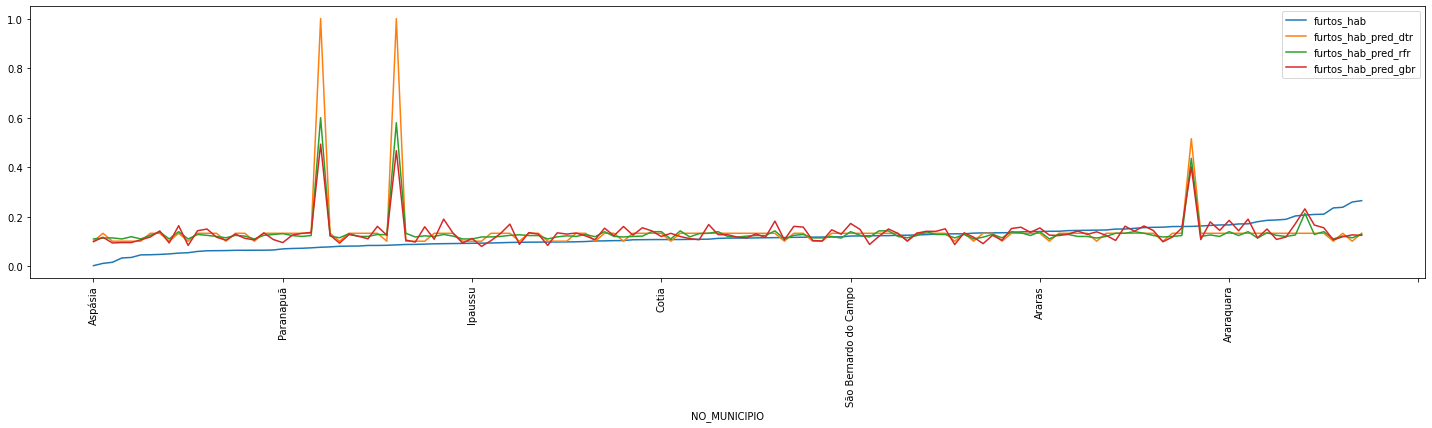

In [7]:
alpha = 0.05

df_x['NO_MUNICIPIO'] = df['NO_MUNICIPIO']

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y_furtos, test_size=0.3, random_state=42)

df_test = X_test.copy()
df_test['furtos_hab'] = y_test

# Regression Tree
dtr = DecisionTreeRegressor(max_depth=dtr_best_params_furtos["max_depth"], random_state=False)
dtr.fit(X_train.drop('NO_MUNICIPIO', axis=1), y_train)
df_test['furtos_hab_pred_dtr'] = dtr.predict(X_test.drop('NO_MUNICIPIO', axis=1))
df_test['residuals_pred_dtr'] = df_test['furtos_hab'] - df_test['furtos_hab_pred_dtr']
ci_dtr = np.quantile(df_test['residuals_pred_dtr'], 1 - alpha)

if ci_dtr >= 0:
    df_test['upper_dtr'] = df_test['furtos_hab'] + ci_dtr
    df_test['lower_dtr'] = df_test['furtos_hab'] - ci_dtr
else:
    df_test['upper_dtr'] = df_test['furtos_hab'] - ci_dtr
    df_test['lower_dtr'] = df_test['furtos_hab'] + ci_dtr

# Random Forest Regressor
rfr = RandomForestRegressor(max_depth=rfr_best_params_furtos["max_depth"], n_estimators=rfr_best_params_furtos["n_estimators"], random_state=False, verbose=False)
rfr.fit(X_train.drop('NO_MUNICIPIO', axis=1), y_train)
df_test['furtos_hab_pred_rfr'] = rfr.predict(X_test.drop('NO_MUNICIPIO', axis=1))
df_test['residuals_pred_rfr'] = df_test['furtos_hab'] - df_test['furtos_hab_pred_rfr']
ci_rfr = np.quantile(df_test['residuals_pred_rfr'], 1 - alpha)

if ci_rfr >= 0:
    df_test['upper_rfr'] = df_test['furtos_hab'] + ci_rfr
    df_test['lower_rfr'] = df_test['furtos_hab'] - ci_rfr
else:
    df_test['upper_rfr'] = df_test['furtos_hab'] - ci_rfr
    df_test['lower_rfr'] = df_test['furtos_hab'] + ci_rfr
    
# Gradient Boosting Regressor
gbr = RandomForestRegressor(max_depth=gbr_best_params_furtos["max_depth"], n_estimators=gbr_best_params_furtos["n_estimators"], random_state=False, verbose=False)
gbr.fit(X_train.drop('NO_MUNICIPIO', axis=1), y_train)
df_test['furtos_hab_pred_gbr'] = gbr.predict(X_test.drop('NO_MUNICIPIO', axis=1))
df_test['residuals_pred_gbr'] = df_test['furtos_hab'] - df_test['furtos_hab_pred_gbr']
ci_gbr = np.quantile(df_test['residuals_pred_gbr'], 1 - alpha)

if ci_rfr >= 0:
    df_test['upper_gbr'] = df_test['furtos_hab'] + ci_gbr
    df_test['lower_gbr'] = df_test['furtos_hab'] - ci_gbr
else:
    df_test['upper_gbr'] = df_test['furtos_hab'] - ci_gbr
    df_test['lower_gbr'] = df_test['furtos_hab'] + ci_gbr



df_test[['NO_MUNICIPIO', 'furtos_hab', 'furtos_hab_pred_dtr', 'furtos_hab_pred_rfr', 'furtos_hab_pred_gbr']].sort_values('furtos_hab').plot.line(x='NO_MUNICIPIO', figsize=(25, 5), rot=90)

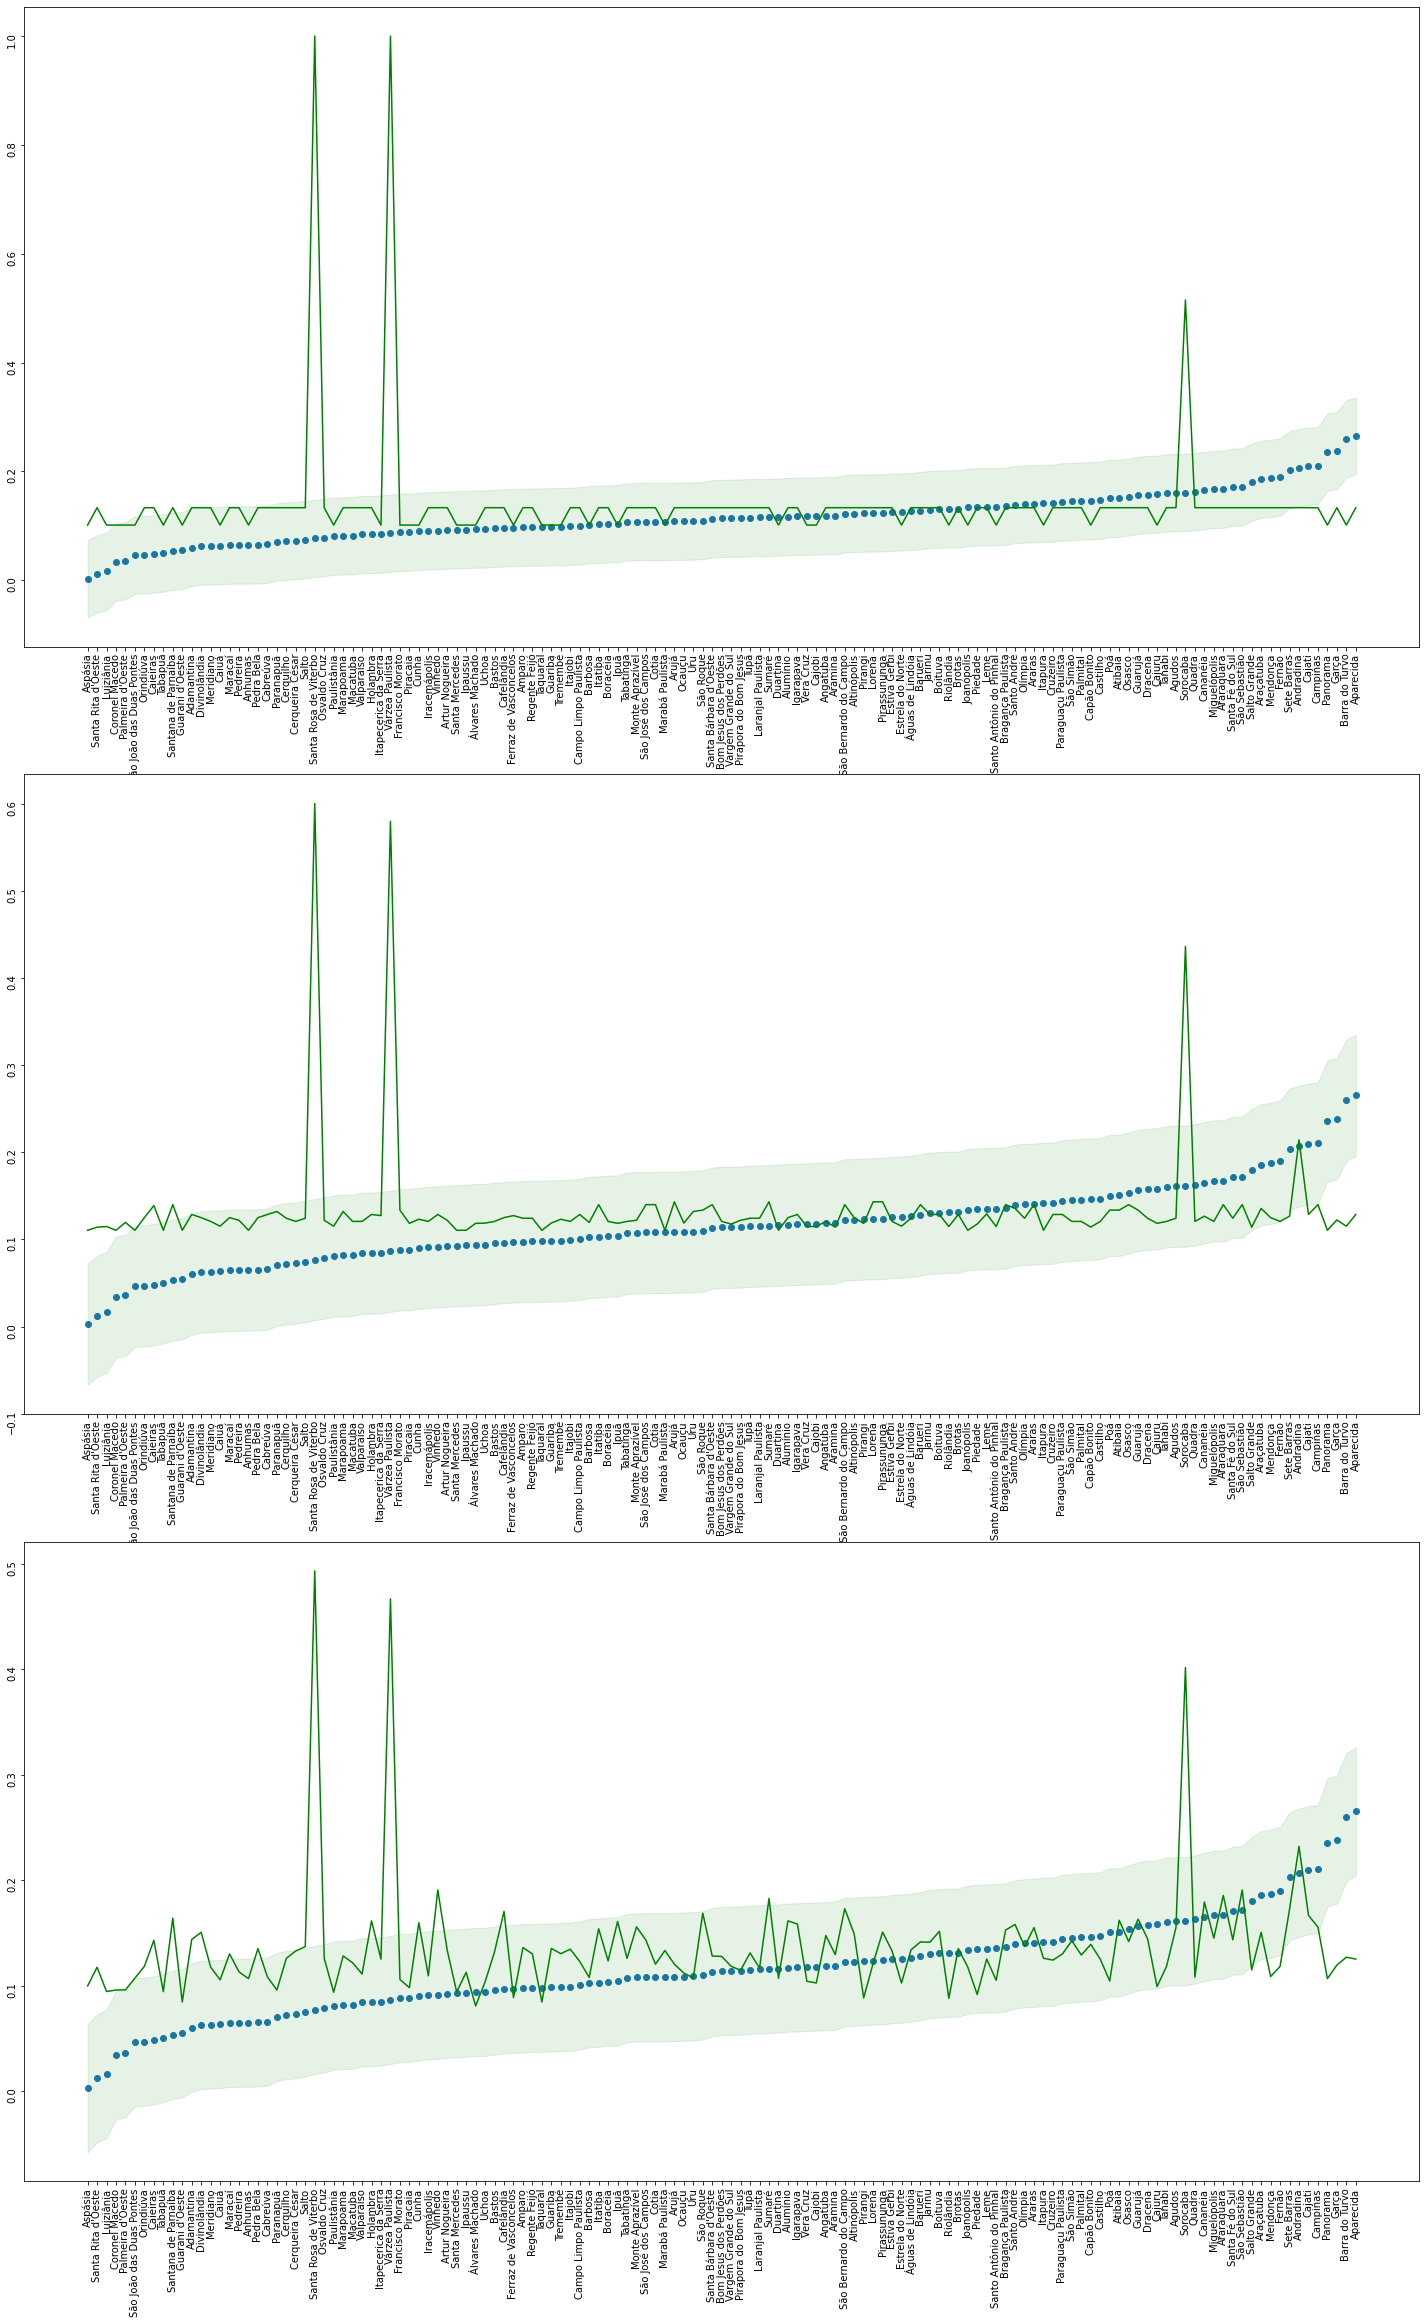

In [8]:
df_temp = df_test[['NO_MUNICIPIO', 'furtos_hab', 'furtos_hab_pred_dtr', 'furtos_hab_pred_rfr', 'furtos_hab_pred_gbr', 
                   'upper_dtr', 'lower_dtr', 'upper_rfr', 'lower_rfr', 'upper_gbr', 'lower_gbr']].sort_values('furtos_hab')

# plt.figure(figsize=(20, 6), dpi=80)
fig, ax = plt.subplots(3, figsize=(25, 40))

# Regression Tree
ax[0].tick_params(labelrotation=90)
ax[0].scatter(df_temp['NO_MUNICIPIO'], df_temp['furtos_hab'])
ax[0].plot(df_temp['NO_MUNICIPIO'],df_temp['furtos_hab_pred_dtr'], color='g')
ax[0].fill_between(df_temp['NO_MUNICIPIO'], df_temp['lower_dtr'], df_temp['upper_dtr'], color='g', alpha=.1)

# Random Forest Regressor
ax[1].tick_params(labelrotation=90)
ax[1].scatter(df_temp['NO_MUNICIPIO'], df_temp['furtos_hab'])
ax[1].plot(df_temp['NO_MUNICIPIO'],df_temp['furtos_hab_pred_rfr'], color='g')
ax[1].fill_between(df_temp['NO_MUNICIPIO'], df_temp['lower_rfr'], df_temp['upper_rfr'], color='g', alpha=.1)

# Gradient Boosting Regressor
ax[2].tick_params(labelrotation=90)
ax[2].scatter(df_temp['NO_MUNICIPIO'], df_temp['furtos_hab'])
ax[2].plot(df_temp['NO_MUNICIPIO'],df_temp['furtos_hab_pred_gbr'], color='g')
ax[2].fill_between(df_temp['NO_MUNICIPIO'], df_temp['lower_gbr'], df_temp['upper_gbr'], color='g', alpha=.1)

### 3.2.2. Murder Data

<AxesSubplot:xlabel='NO_MUNICIPIO'>

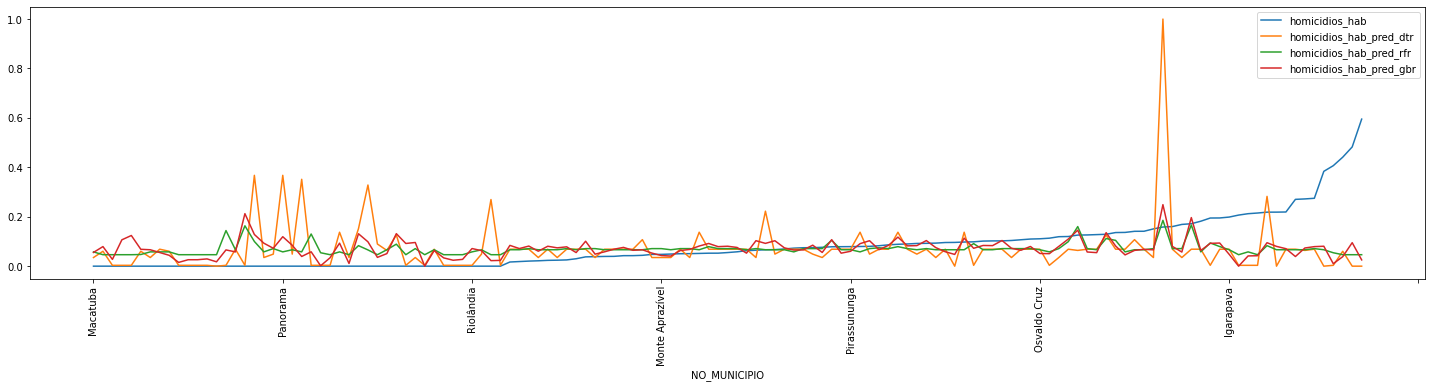

In [9]:
alpha = 0.05

df_x['NO_MUNICIPIO'] = df['NO_MUNICIPIO']

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y_homicidios, test_size=0.3, random_state=42)

df_test = X_test.copy()
df_test['homicidios_hab'] = y_test

# Regression Tree
dtr = DecisionTreeRegressor(max_depth=dtr_best_params_homicidios["max_depth"], random_state=False)
dtr.fit(X_train.drop('NO_MUNICIPIO', axis=1), y_train)
df_test['homicidios_hab_pred_dtr'] = dtr.predict(X_test.drop('NO_MUNICIPIO', axis=1))
df_test['residuals_pred_dtr'] = df_test['homicidios_hab'] - df_test['homicidios_hab_pred_dtr']
ci_dtr = np.quantile(df_test['residuals_pred_dtr'], 1 - alpha)

if ci_dtr >= 0:
    df_test['upper_dtr'] = df_test['homicidios_hab'] + ci_dtr
    df_test['lower_dtr'] = df_test['homicidios_hab'] - ci_dtr
else:
    df_test['upper_dtr'] = df_test['homicidios_hab'] - ci_dtr
    df_test['lower_dtr'] = df_test['homicidios_hab'] + ci_dtr

# Random Forest Regressor
rfr = RandomForestRegressor(max_depth=rfr_best_params_furtos["max_depth"], n_estimators=rfr_best_params_furtos["n_estimators"], random_state=False, verbose=False)
rfr.fit(X_train.drop('NO_MUNICIPIO', axis=1), y_train)
df_test['homicidios_hab_pred_rfr'] = rfr.predict(X_test.drop('NO_MUNICIPIO', axis=1))
df_test['residuals_pred_rfr'] = df_test['homicidios_hab'] - df_test['homicidios_hab_pred_rfr']
ci_rfr = np.quantile(df_test['residuals_pred_rfr'], 1 - alpha)

if ci_rfr >= 0:
    df_test['upper_rfr'] = df_test['homicidios_hab'] + ci_rfr
    df_test['lower_rfr'] = df_test['homicidios_hab'] - ci_rfr
else:
    df_test['upper_rfr'] = df_test['homicidios_hab'] - ci_rfr
    df_test['lower_rfr'] = df_test['homicidios_hab'] + ci_rfr
    
# Gradient Boosting Regressor
gbr = RandomForestRegressor(max_depth=gbr_best_params_furtos["max_depth"], n_estimators=gbr_best_params_furtos["n_estimators"], random_state=False, verbose=False)
gbr.fit(X_train.drop('NO_MUNICIPIO', axis=1), y_train)
df_test['homicidios_hab_pred_gbr'] = gbr.predict(X_test.drop('NO_MUNICIPIO', axis=1))
df_test['residuals_pred_gbr'] = df_test['homicidios_hab'] - df_test['homicidios_hab_pred_gbr']
ci_gbr = np.quantile(df_test['residuals_pred_gbr'], 1 - alpha)

if ci_rfr >= 0:
    df_test['upper_gbr'] = df_test['homicidios_hab'] + ci_gbr
    df_test['lower_gbr'] = df_test['homicidios_hab'] - ci_gbr
else:
    df_test['upper_gbr'] = df_test['homicidios_hab'] - ci_gbr
    df_test['lower_gbr'] = df_test['homicidios_hab'] + ci_gbr



df_test[['NO_MUNICIPIO', 'homicidios_hab', 'homicidios_hab_pred_dtr', 'homicidios_hab_pred_rfr', 'homicidios_hab_pred_gbr']].sort_values('homicidios_hab').plot.line(x='NO_MUNICIPIO', figsize=(25, 5), rot=90)

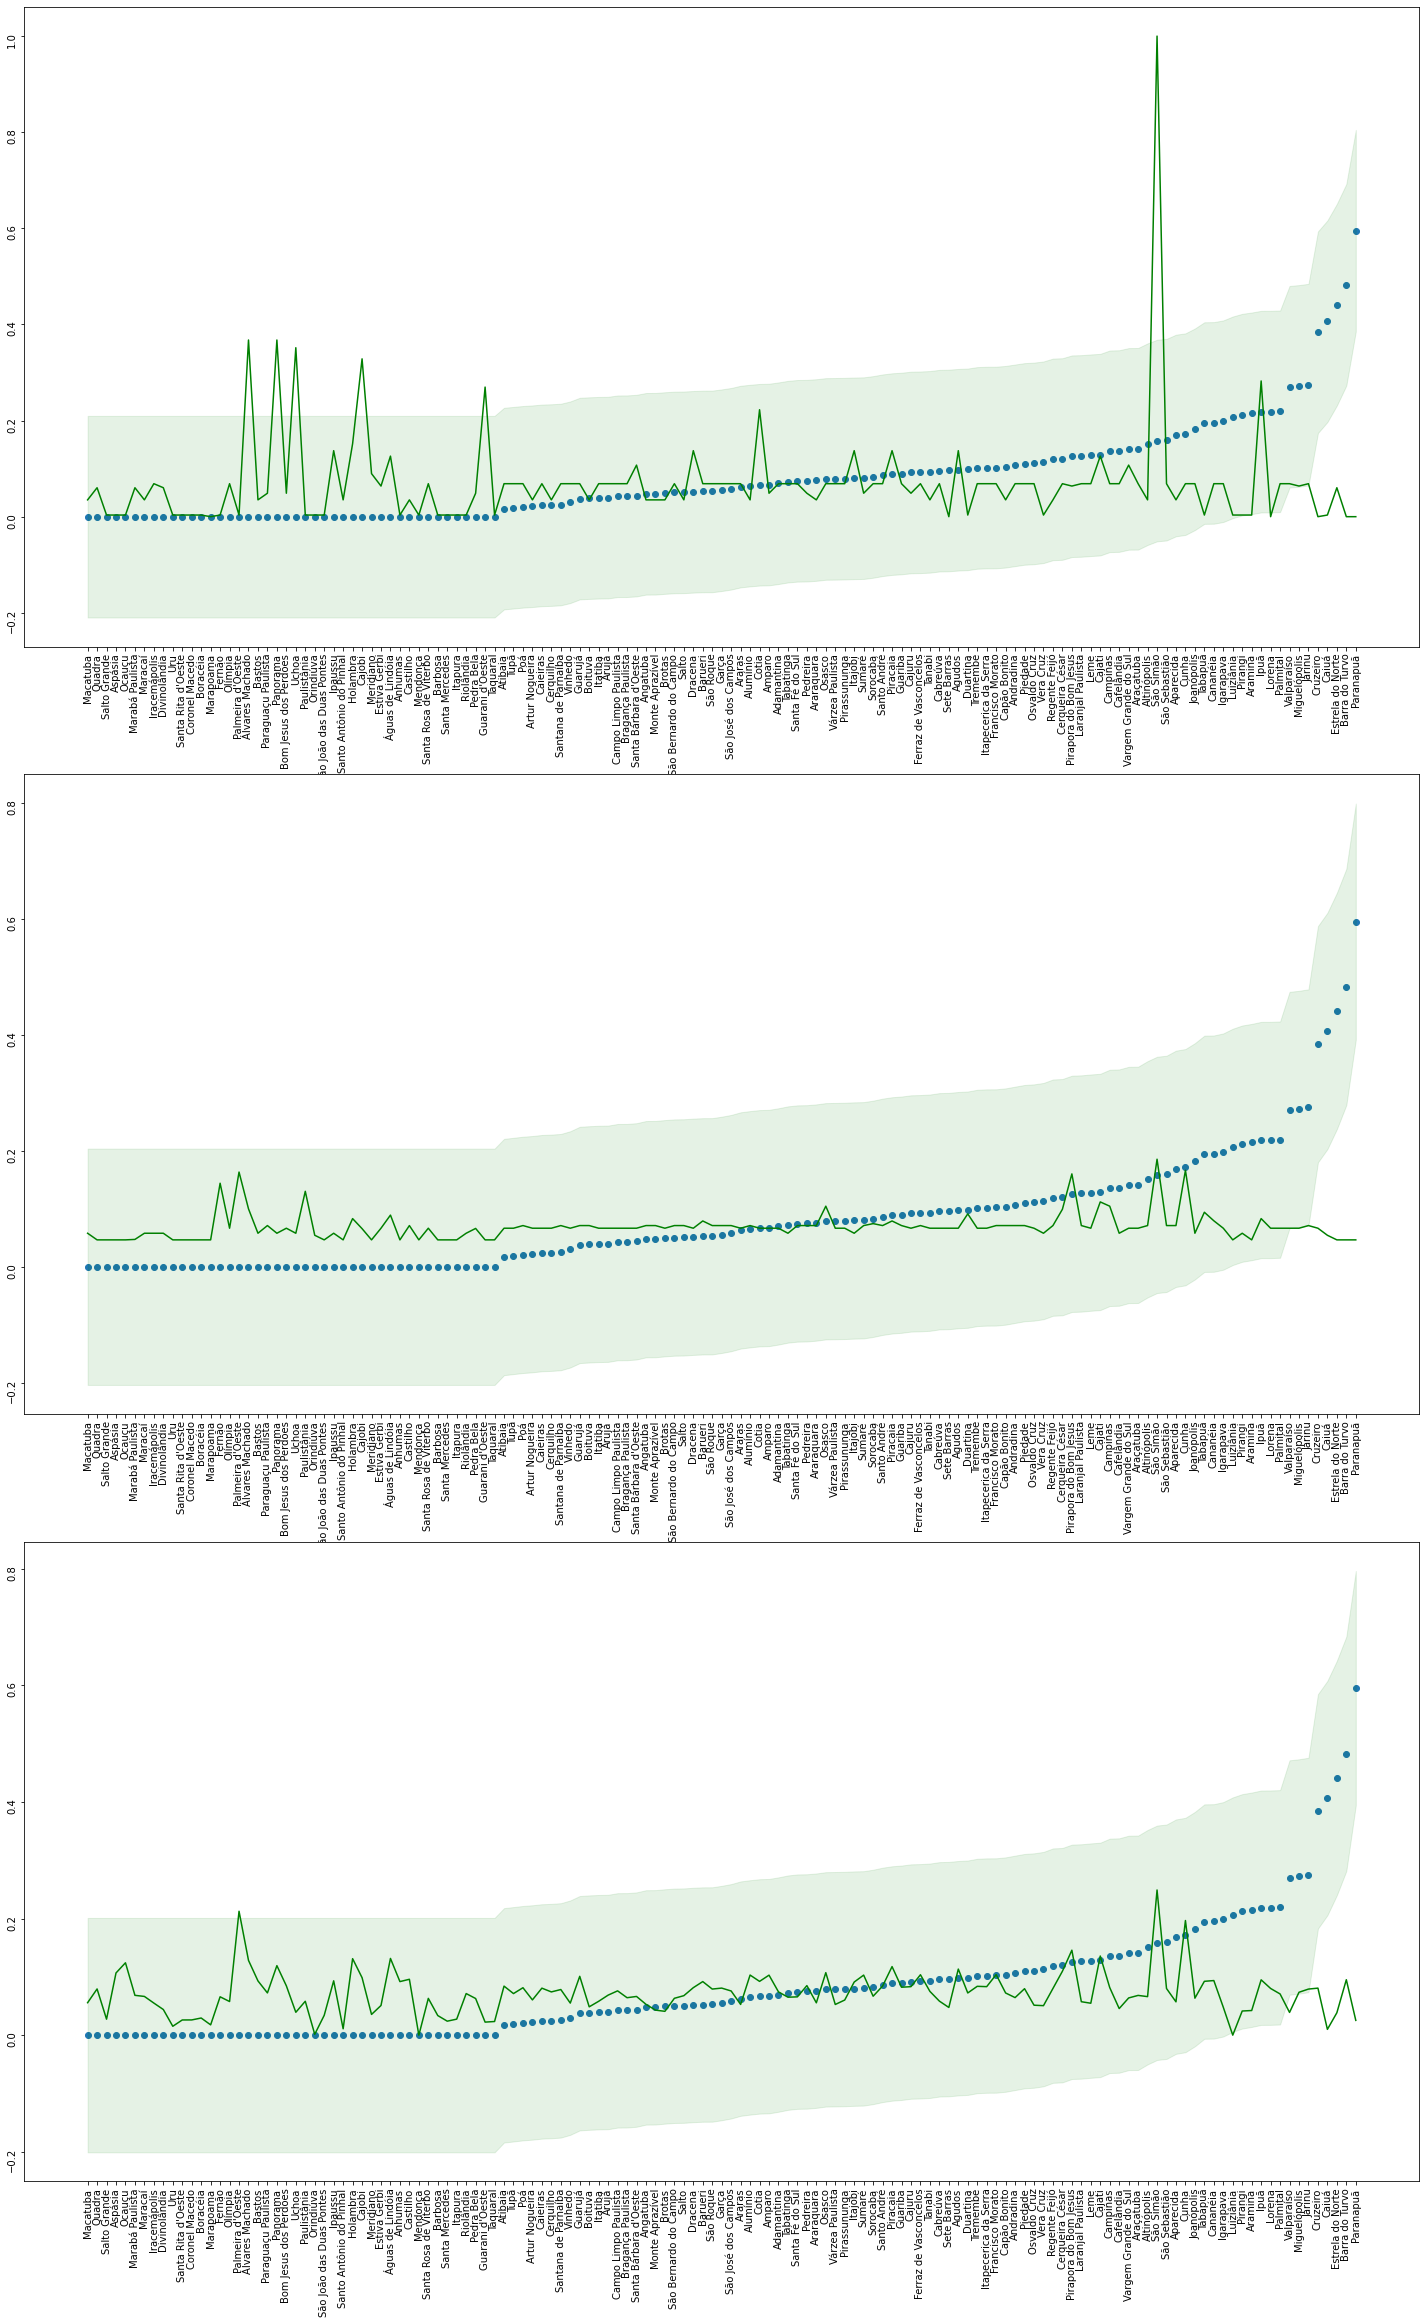

In [10]:
df_temp = df_test[['NO_MUNICIPIO', 'homicidios_hab', 'homicidios_hab_pred_dtr', 'homicidios_hab_pred_rfr', 'homicidios_hab_pred_gbr', 
                   'upper_dtr', 'lower_dtr', 'upper_rfr', 'lower_rfr', 'upper_gbr', 'lower_gbr']].sort_values('homicidios_hab')

# plt.figure(figsize=(20, 6), dpi=80)
fig, ax = plt.subplots(3, figsize=(25, 40))

# Regression Tree
ax[0].tick_params(labelrotation=90)
ax[0].scatter(df_temp['NO_MUNICIPIO'], df_temp['homicidios_hab'])
ax[0].plot(df_temp['NO_MUNICIPIO'],df_temp['homicidios_hab_pred_dtr'], color='g')
ax[0].fill_between(df_temp['NO_MUNICIPIO'], df_temp['lower_dtr'], df_temp['upper_dtr'], color='g', alpha=.1)

# Random Forest Regressor
ax[1].tick_params(labelrotation=90)
ax[1].scatter(df_temp['NO_MUNICIPIO'], df_temp['homicidios_hab'])
ax[1].plot(df_temp['NO_MUNICIPIO'],df_temp['homicidios_hab_pred_rfr'], color='g')
ax[1].fill_between(df_temp['NO_MUNICIPIO'], df_temp['lower_rfr'], df_temp['upper_rfr'], color='g', alpha=.1)

# Gradient Boosting Regressor
ax[2].tick_params(labelrotation=90)
ax[2].scatter(df_temp['NO_MUNICIPIO'], df_temp['homicidios_hab'])
ax[2].plot(df_temp['NO_MUNICIPIO'],df_temp['homicidios_hab_pred_gbr'], color='g')
ax[2].fill_between(df_temp['NO_MUNICIPIO'], df_temp['lower_gbr'], df_temp['upper_gbr'], color='g', alpha=.1)